# TWS 3 Project

Install deps

In [2]:
! pip3 install ib_insync
! pip3 install pandas
! pip3 install openpyxl
! pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 18.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.7 MB/s eta 0:00:00


Instantiate the IB api

_Make sure to have TWS running_

In [4]:
from ib_insync import *
import pandas as pd

util.startLoop() # necessary for notebook

ib = IB()
ib.connect()
ib.reqMarketDataType(3)

Create the list of contracts

In [5]:
from ib_insync import contract

contractInfos = [
    {
        "conId": 296574745,
        "exchange": "NYMEX",
    },
    {
        "conId": 297249704,
        "exchange": "IPE",
    },
    {
        "conId": 7089,
        "exchange": "NYSE",
    },
    {
        "conId": 470458975,
        "exchange": "NYSE",
    },
    {
        "conId": 4215217,
        "exchange": "NYSE",
    },
    {
        "conId": 13977,
        "exchange": "NYSE",
    },
    {
        "conId": 6890,
        "exchange": "NYSE",
    },
    {
        "conId": 5684,
        "exchange": "NYSE",
    },
    {
        "conId": 754442,
        "exchange": "NYSE",
    },
    {
        "conId": 10885,
        "exchange": "NYSE",
    },
    {
        "conId": 57698865,
        "exchange": "NYSE",
    },
    {
        "conId": 39118796,
        "exchange": "NYSE",
    },
    {
        "conId": 9831,
        "exchange": "NYSE",
    },
    {
        "conId": 3142097,
        "exchange": "NYSE",
    },
    {
        "conId": 6608450,
        "exchange": "NYSE",
    },
    {
        "conId": 13805,
        "exchange": "NYSE",
    },
    {
        "conId": 75960201,
        "exchange": "NYSE",
    },
    {
        "conId": 418893644,
        "exchange": "NYSE",
    },
    {
        "conId": 10190340,
        "exchange": "NYSE",
    },
    {
        "conId": 415578515,
        "exchange": "NYSE",
    },
    {
        "conId": 495512572,
        "exchange": "CME",
    },
    {
        "conId": 551601503,
        "exchange": "CBOT",
    },
]

contracts = [contract.Contract(**info) for info in contractInfos]

And lets now "qualify" (fill missing values such as `symbol`) the contracts

In [6]:
for contract in contracts:
    ib.qualifyContracts(contract)

contracts[0]

Contract(secType='FUT', conId=296574745, symbol='CL', lastTradeDateOrContractMonth='20230120', multiplier='1000', exchange='NYMEX', currency='USD', localSymbol='CLG3', tradingClass='CL')

Next we define 2 useful variables

In [7]:
duration_strs = ["11 D", "31 D", "91 D"]
duration_strs_sheets = ["10-days", "30-days", "90-days"]

With that out of the way, lets start making the important requests :)
We'll make a new Dict looking like this: dict[str, dict[str, BarDataList]]
                                         dict[Symbol, dict['10-days', Historical Data]]
## IMPORTANT
This is ONLY if you wanna start the whole process from scratch making new data, if you have them in your filesystem as excel sheets already, head down to **import data from excel**

In [ ]:
from datetime import datetime

query_date = datetime.now().strftime("%Y%m%d-00:00:00")

historical_datas = {contract.symbol: {duration_sheet: ib.reqHistoricalData(contract, query_date, duration_str, "10 mins", "TRADES", True) for duration_str, duration_sheet in zip(duration_strs, duration_strs_sheets)} for contract in contracts}

Lets now transform all of these historical datas into pandas DataFrames, removing possible None values

In [26]:
from pandas import DataFrame 

historical_datas_df: dict[str, dict[str, DataFrame]] = {
    contract: dict(filter(lambda item: item[1] is not None, {
        duration_sheet: util.df(historical_data) for duration_sheet, historical_data in historical_data_duration.items()
        }.items())) for contract, historical_data_duration in historical_datas.items()
    }

historical_datas_df[contracts[5].symbol][duration_strs_sheets[1]].tail(10)

,date,open,high,low,close,volume,average,barCount
1199,2023-01-11 14:20:00-05:00,110.63,111.02,110.62,110.89,62563.0,110.856,348
1200,2023-01-11 14:30:00-05:00,110.88,111.07,110.87,110.95,33121.0,110.991,229
1201,2023-01-11 14:40:00-05:00,110.96,110.97,110.88,110.92,38333.0,110.921,206
1202,2023-01-11 14:50:00-05:00,110.92,111.15,110.89,111.10,57668.0,110.996,277
1203,2023-01-11 15:00:00-05:00,111.10,111.17,111.03,111.10,45118.0,111.111,259
1204,2023-01-11 15:10:00-05:00,111.10,111.23,111.07,111.14,39578.0,111.162,213
1205,2023-01-11 15:20:00-05:00,111.14,111.25,111.05,111.25,48267.0,111.132,258
1206,2023-01-11 15:30:00-05:00,111.24,111.24,111.02,111.14,80168.0,111.131,422
1207,2023-01-11 15:40:00-05:00,111.14,111.35,110.97,111.33,129837.0,111.152,608
1208,2023-01-11 15:50:00-05:00,111.30,111.45,111.21,111.37,416851.0,111.337,1511


Lets cook a function that does the heavy data munging and call it
This removes a bunch of useful data, computes averages, price differences, volume differences and whatever
## DO THIS EVEN IF YOU IMPORT DATAS

In [8]:
def prepare_data_from_tws(df: pd.DataFrame) -> pd.DataFrame:
    #                           date   open   high    low  close  volume  average  barCount
    # 0    2022-09-05 15:50:00+01:00  86.39  86.39  86.39  86.39     1.0   86.390         1
    df["time"] = df["date"].dt.time
    df["date"] = df["date"].dt.date
    df.rename(columns={"close": "price"}, inplace=True)
    df = df[df["time"] <= datetime.strptime("16:00:00", "%H:%M:%S").time()]
    df = df[
        df["time"] >= datetime.strptime("9:30:00", "%H:%M:%S").time()
    ].reset_index(drop=True)
    df["nterm"] = df.index
    df = df[
        [
            "nterm",
            "date",
            "time",
            "price",
            "volume",
        ]
    ]
    df["total_daily_volume"] = df.groupby("date")["volume"].transform("sum")
    df = df.merge(
        df.groupby("date")["price"].last().shift(1), on="date"
    ).rename(columns={"price_y": "yesterday_close", "price_x": "price"})
    df["flat_delta_px_prev_bar"] = df["price"] - df["price"].shift(1)
    df["percent_delta_px_prev_bar"] = (
        df["flat_delta_px_prev_bar"] / df["price"].shift(1) * 100
    )
    df["flat_delta_px_close"] = df["price"] - df["yesterday_close"]
    df["percent_delta_px_close"] = (
        df["flat_delta_px_close"] / df["yesterday_close"] * 100
    )
    df = df.merge(
        df.groupby("date")["total_daily_volume"].first().shift(1), on="date"
    ).rename(
        columns={
            "total_daily_volume_y": "total_daily_volume_prev_day",
        }
    )
    for i in range(len(df)):
        for prev_row in range(i - 1, -1, -1):
            if df.iloc[prev_row]["time"] == df.iloc[i]["time"]:
                df.at[i, "prev_day_volume"] = df.at[prev_row, "volume"]
                break

    df = df[
        [
            "nterm",
            "date",
            "time",
            "price",
            "volume",
            "prev_day_volume",
            "total_daily_volume_prev_day",
            "yesterday_close",
            "flat_delta_px_prev_bar",
            "percent_delta_px_prev_bar",
            "flat_delta_px_close",
            "percent_delta_px_close",
        ]
    ]
    df["flat_delta_px_next_bar"] = df["flat_delta_px_prev_bar"].shift(-1)
    df["percent_delta_px_next_bar"] = df["percent_delta_px_prev_bar"].shift(-1)
    df["flat_delta_px_close_plus_one"] = df["flat_delta_px_close"].shift(-1)
    df["percent_delta_px_close_plus_one"] = df["percent_delta_px_close"].shift(
        -1
    )
    df["flat_delta_volume_prev_day"] = df["volume"] - df["prev_day_volume"]
    df["percent_delta_volume_prev_day"] = (
        df["flat_delta_volume_prev_day"] / df["prev_day_volume"]
    ) * 100
    df["percent_prev_daily_volume"] = (
        (df["volume"]) / df["total_daily_volume_prev_day"] * 100
    )
    df["average_volume"] = df["volume"].cumsum() / (df.index + 1)
    df["ema_5"] = df["price"].ewm(span=5).mean()
    df["ema_20"] = df["price"].ewm(span=15).mean()
    return df

Apply the transformations

In [ ]:
historical_datas_df = {contract: {duration_sheet: prepare_data_from_tws(df) for duration_sheet, df in duration_df.items()} for contract, duration_df in historical_datas_df.items()}
historical_datas_df[contracts[5].symbol][duration_strs_sheets[2]].tail(10)

Save data in excel

In [ ]:
import os

for contract_name, duration_df in historical_datas_df.items():
    if not os.path.exists(f"./outputs/{contract_name}"):
        os.mkdir(f"./outputs/{contract_name}")
    with pd.ExcelWriter(f"./outputs/{contract_name}/spreadsheet.xlsx") as writer:
        for duration_strs_sheet in duration_strs_sheets:
            duration_df[duration_strs_sheet].to_excel(writer, sheet_name=duration_strs_sheet, index=False)

    with pd.ExcelWriter(f"./outputs/{contract_name}/correlations.xlsx") as writer:
        for duration_strs_sheet in duration_strs_sheets:
            corr_matrix = duration_df[duration_strs_sheet].corr()
            corr_matrix.to_excel(writer, sheet_name=duration_strs_sheet)

## IMPORT DATA FROM EXCEL
If you've already run all this process before, just import the spreadsheets into variables and get going!

In [9]:
historical_datas_df = {contract.symbol: {duration_sheet: pd.read_excel(f"./outputs/{contract.symbol}/spreadsheet.xlsx", sheet_name=duration_sheet) for duration_sheet in duration_strs_sheets} for contract in contracts}
historical_datas_df[contracts[5].symbol][duration_strs_sheets[1]].tail(10)

,nterm,date,time,price,volume,prev_day_volume,total_daily_volume_prev_day,yesterday_close,flat_delta_px_prev_bar,percent_delta_px_prev_bar,...,flat_delta_px_next_bar,percent_delta_px_next_bar,flat_delta_px_close_plus_one,percent_delta_px_close_plus_one,flat_delta_volume_prev_day,percent_delta_volume_prev_day,percent_prev_daily_volume,average_volume,ema_5,ema_20
1199,1199,2023-01-11,14:20:00,110.89,62563,41775.0,1761611.0,110.1,0.29,0.262206,...,0.06,0.054108,0.85,0.772025,20788.0,49.761819,3.551465,57303.116667,110.660824,110.482706
1200,1200,2023-01-11,14:30:00,110.95,33121,26642.0,1761611.0,110.1,0.06,0.054108,...,-0.03,-0.027039,0.82,0.744777,6479.0,24.318745,1.880154,57282.981682,110.757216,110.541117
1201,1201,2023-01-11,14:40:00,110.92,38333,23292.0,1761611.0,110.1,-0.03,-0.027039,...,0.18,0.162279,1.00,0.908265,15041.0,64.575820,2.176020,57267.216306,110.811477,110.588478
1202,1202,2023-01-11,14:50:00,111.10,57668,20594.0,1761611.0,110.1,0.18,0.162279,...,0.00,0.000000,1.00,0.908265,37074.0,180.023308,3.273594,57267.549460,110.907652,110.652418
1203,1203,2023-01-11,15:00:00,111.10,45118,16787.0,1761611.0,110.1,0.00,0.000000,...,0.04,0.036004,1.04,0.944596,28331.0,168.767499,2.561178,57257.458472,110.971768,110.708366
1204,1204,2023-01-11,15:10:00,111.14,39578,31537.0,1761611.0,110.1,0.04,0.036004,...,0.11,0.098974,1.15,1.044505,8041.0,25.497035,2.246694,57242.786722,111.027845,110.762320
1205,1205,2023-01-11,15:20:00,111.25,48267,54828.0,1761611.0,110.1,0.11,0.098974,...,-0.11,-0.098876,1.04,0.944596,-6561.0,-11.966513,2.739935,57235.344113,111.101897,110.823280
1206,1206,2023-01-11,15:30:00,111.14,80168,48234.0,1761611.0,110.1,-0.11,-0.098876,...,0.19,0.170956,1.23,1.117166,31934.0,66.206410,4.550834,57254.343828,111.114598,110.862870
1207,1207,2023-01-11,15:40:00,111.33,129837,101815.0,1761611.0,110.1,0.19,0.170956,...,0.04,0.035929,1.27,1.153497,28022.0,27.522467,7.370356,57314.428808,111.186399,110.921261
1208,1208,2023-01-11,15:50:00,111.37,416851,273169.0,1761611.0,110.1,0.04,0.035929,...,NaN,NaN,NaN,NaN,143682.0,52.598208,23.663056,57611.812242,111.247599,110.977354


Let's now execute (simulate lol) some trades based on these:

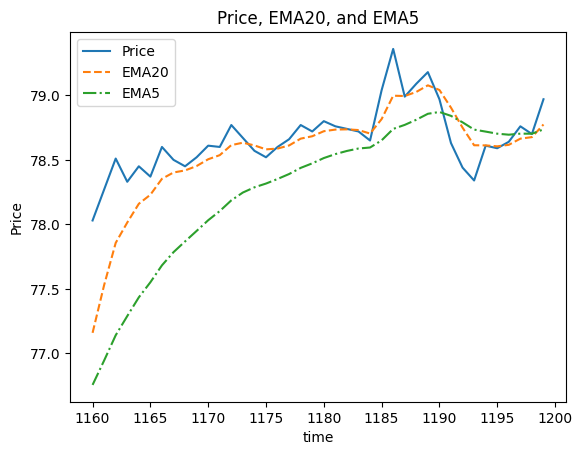

Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IB and Trader Workstation has been restored - data maintained. All data farms are connected: cashfarm; uscrypto; usfuture.nj; usfuture; usfarm.nj; usfarm; euhmds; ushmds.nj; fundfarm; ushmds; secdefil.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IB and Trader Workstation has been restored - data maintained. All data farms are connected: cashfarm; uscrypto; usfuture.nj; usfuture; usfarm.nj; usfarm; euhmds; ushmds.nj; fundfarm; ushmds; secdefil.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IB and Trader Workstation has been restored - data maintained. All data farms are connected: cashfarm; uscrypto; usfuture.nj; usfuture; usfarm.nj; usfarm; euhmds; ushmds.nj; fundfarm; ushmds; secdefil.
Error 1100, r

In [38]:
from datetime import datetime
# import matplotlib.pyplot as plt

for contract in contracts: #[2:3]:
    query_date = datetime.now().strftime("%Y%m%d-00:00:00")
    bars = ib.reqHistoricalData(contract, endDateTime=query_date, durationStr='30 D', barSizeSetting='10 mins', whatToShow='TRADES', useRTH=True)
    df = util.df(bars)
    if df is None:
        continue

    df = prepare_data_from_tws(df)
    df = df[df["date"] == df.tail(1)["date"].values[0]]
    # # plot df
    # df[["price", "ema_5", "ema_20"]].plot(style=['-', '--', '-.', ':'])
    # plt.xlabel('time')
    # plt.ylabel('Price')
    # plt.title('Price, EMA20, and EMA5')
    # plt.legend(['Price', 'EMA20', 'EMA5'])
    # plt.show()

    selling_df = df[(df["ema_5"] < df["ema_20"]) & (df["ema_5"].shift(1) > df["ema_20"].shift(1))]
    selling_df["order"] = "SELL"
    buying_df = df[(df["ema_5"] > df["ema_20"]) & (df["ema_5"].shift(1) < df["ema_20"].shift(1))]
    buying_df["order"] = "BUY"
    orders_df = pd.concat([selling_df, buying_df])
    orders_df = orders_df[orders_df["volume"] > 2 * orders_df["average_volume"]]
    orders_df = orders_df[["date", "order", "price"]]
    orders_df.sort_index(inplace=True)
    orders_df.to_csv(f"./outputs/{contract.symbol}/orders.csv", index=False)
